<a href="https://colab.research.google.com/github/nevzatseferoglu/graph-embedding/blob/main/custom_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version
!pip install stellargraph

import os
import random
import pickle
import json

import matplotlib.pyplot as plt
import matplotlib.pylab
import numpy as np
import pandas as pd
import networkx as nx

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from gensim.models import Word2Vec

%matplotlib inline
plt.rcParams['figure.constrained_layout.use'] = True

In [103]:
# utilities

def save_visual_graph(steller_graph, filename):
    random_nx = steller_graph.to_networkx()
    fig, ax = plt.subplots(num=None, figsize=(15, 15), dpi=60)
    plt.axis('off')
    pos = nx.spring_layout(random_nx, seed=7)
    nx.draw_networkx_nodes(random_nx, pos, node_size=20, node_color='red')
    nx.draw_networkx_edges(random_nx, pos, width=0.5)
    nx.draw_networkx_labels(random_nx,pos)
    plt.savefig(filename, bbox_inches="tight")
    del fig

def save_graph_dataset(df_nodes, df_edges, nodes_file_output_name='nodes.csv', edges_file_output_name='edges.csv'):
    dir_name = 'dataset'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    nodes_csv = os.path.join(dir_name, nodes_file_output_name)
    edges_csv = os.path.join(dir_name, edges_file_output_name)
    df_nodes.to_csv(nodes_csv)
    df_edges.to_csv(edges_csv)

def save_model_with_params(params, params_output_name='params.pck'):
    dir_name = 'params'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    fullpath = os.path.join(dir_name, params_output_name)
    pck = open(fullpath, 'wb')
    pickle.dump(params, pck)
    pck.close()


In [104]:
# graph component initialization

NODE_SIZE = 1000                                                    # node size
NODE_FEATURE_TYPE_COLLECTION = {                                    # feature collection
    'nf_1': (-1, -2, -3, -4, -5),
    'nf_2': (0.1, 0.2, 0.3, 0.4, 0.5)
}
NODE_FEATURE_1_LOOK_UP = {-1:'A', -2:'B', -3:'C', -4:'D', -5: 'E'} # look-up table for feature  
EDGE_WEIGHT_BOUNDARIES = (0.1, 5.0)                                # edge weight
NETWORKX_VISUAL_OUTPUT = 'homogenous-graph.png'                    # graph visualization output filepath

In [105]:
# generating edges based on the given feature(s)

nf_1_len = len(NODE_FEATURE_TYPE_COLLECTION['nf_1'])
nf_2_len = len(NODE_FEATURE_TYPE_COLLECTION['nf_2'])
assert nf_1_len == nf_2_len

from_node_ids = np.random.choice(np.arange(0, NODE_SIZE, dtype=int), replace=False, size=NODE_SIZE)
from_node_ids = np.concatenate((from_node_ids, np.array(NODE_FEATURE_TYPE_COLLECTION['nf_1'])))
assert len(np.unique(from_node_ids)) == len(from_node_ids) == NODE_SIZE + nf_1_len

nf_1 = np.array([random.choice(NODE_FEATURE_TYPE_COLLECTION['nf_1']) for i in range(NODE_SIZE+nf_1_len)])
nf_1[-1*nf_1_len:] = np.full(nf_1_len, 1)
nf_2 = np.array([random.choice(NODE_FEATURE_TYPE_COLLECTION['nf_2']) for i in range(NODE_SIZE+nf_2_len)])
nf_2[-1*nf_2_len:] = np.full(nf_2_len, 1)

# DataFrame new features to the nodes
random_node_data = pd.DataFrame(
    {'nf_1': nf_1, 'nf_2': nf_2}, index=from_node_ids
)

# DataFrame describes to connection between nodes
random_weighted_edges = pd.DataFrame({
    'source': from_node_ids,
    'target': nf_1,
    'weight': np.random.uniform(low=EDGE_WEIGHT_BOUNDARIES[0], high=EDGE_WEIGHT_BOUNDARIES[1], size=(NODE_SIZE+nf_1_len,))
})

save_graph_dataset(random_node_data, random_weighted_edges) # export node and edge dataframes as a dataset

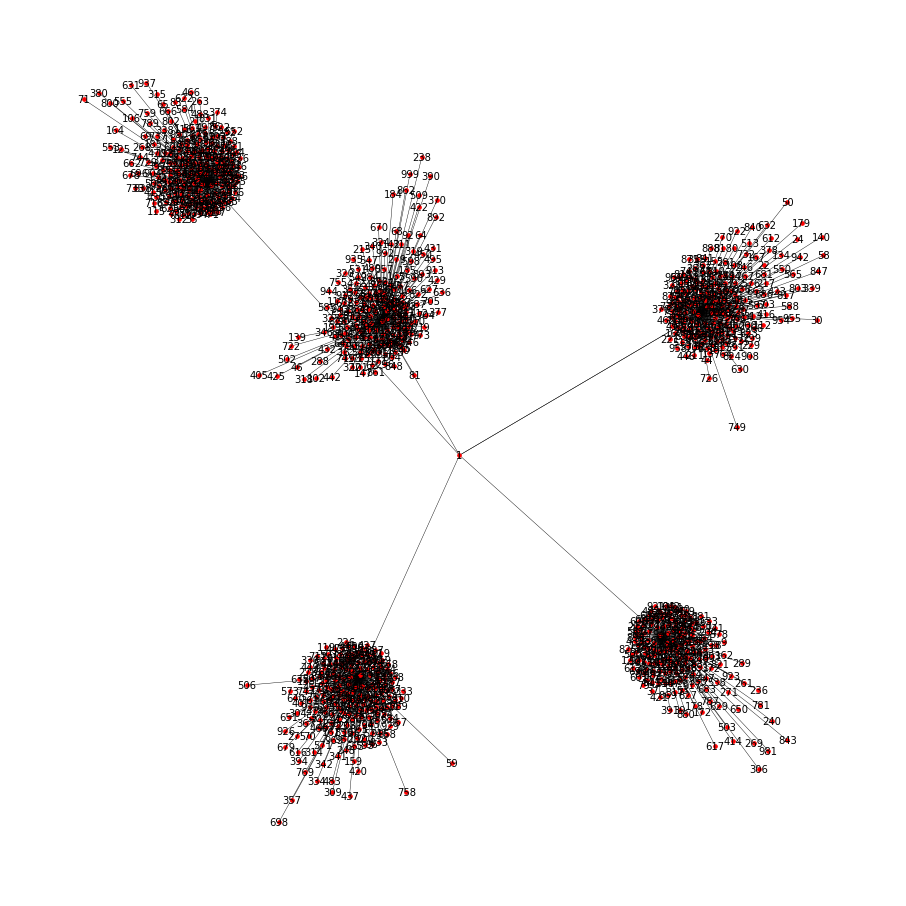

In [107]:
random_node_data = pd.read_csv('dataset/nodes.csv', index_col=0)        # read nodes dataframe
random_weighted_edges = pd.read_csv('dataset/edges.csv', index_col=0)   # read edges dataframe

G = StellarGraph(random_node_data, random_weighted_edges)   # initialize Stellar Graph
save_visual_graph(G, NETWORKX_VISUAL_OUTPUT)                # export networkx visualization of the stellar graph

In [96]:
params = {
    'length': 100,
    'n': 10,
    'p': 0.5,
    'q': 0.5,
    'size': 128,
    'window': 5,
    'min_count': 0,
    'sg': 1,
    'workers': 2,
    'iter': 1,
    'model': None,
    'graph': G
}

rw = BiasedRandomWalk(G)    # initalize biased second order random walks
walks = rw.run(
    nodes=list(G.nodes()),      # root nodes
    length=params['length'],    # maximum length of a random walk
    n=params['n'],              # number of random walks per root node
    p=params['p'],              # Defines (unormalised) probability, 1/p, of returning to source node
    q=params['q'],              # Defines (unormalised) probability, 1/q, for moving away from source node
)

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, 
                 size=params['size'], 
                 window=params['window'], 
                 min_count=params['min_count'], 
                 sg=params['sg'], 
                 workers=params['workers'], 
                 iter=params['iter'])

params['model'] = model

save_model_with_params(params) # export processed model and its parameters

In [ ]:
with open("params/params.pck", "rb") as f:
    params = pickle.load(f) # load model and walk parameters from the file
    model = params['model']
    f.close()

node_ids = model.wv.index2word
node_embeddings = (         # get the embeddings
    model.wv.vectors 
)

random_node_data = pd.read_csv('dataset/nodes.csv', index_col=0)        # read nodes dataframe
node_targets = random_node_data['nf_1'][[int(node_id) for node_id in node_ids]]

# apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

[]

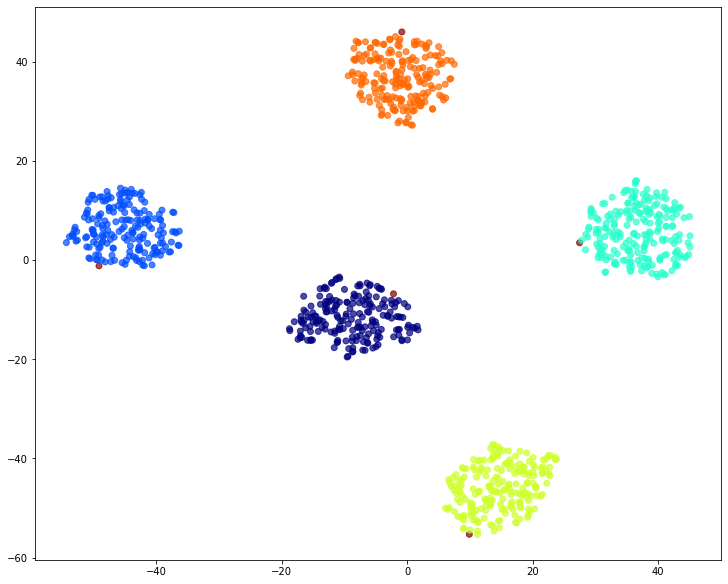

In [106]:
fig, ax = plt.subplots(figsize=(10, 8)) # display the TSNE
ax.scatter(
    node_embeddings_2d[:, 0],           # x axis
    node_embeddings_2d[:, 1],           # y axis
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.plot(label='Inline label')